In [31]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numba import prange, njit
import time
from mpl_toolkits.mplot3d import Axes3D
from fireworks.ic import ic_tf as fic_tf 
from fireworks.ic import ic as fic
import fireworks.nbodylib.integrators as fint
import fireworks.nbodylib.dynamics as fdyn
import fireworks.nbodylib.timesteps as ftim
from tqdm.notebook import tqdm
from fireworks.particles import Particles_tf,Particles
import multiprocessing
from multiprocessing import Pool
import psutil
from matplotlib.animation import FuncAnimation


tf.config.optimizer.set_jit(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # Ensure TensorFlow is configured to use the GPU
assert tf.test.is_gpu_available(), "No GPU detected or TensorFlow is not configured to use it."


Num GPUs Available:  1


2024-05-28 01:42:08.972765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 01:42:08.973278: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 01:42:08.973658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [48]:
def generate_initial_conditions(N: int) -> Particles_tf:
    # Generate random positions, velocities, and masses
    position = tf.random.uniform(shape=(N, 3), dtype=tf.float32)
    velocity = tf.random.uniform(shape=(N, 3), dtype=tf.float32)
    mass = tf.random.uniform(shape=(N,), dtype=tf.float32)
    return Particles_tf(position=position, velocity=velocity, mass=mass)
def manual_initial_conditions() -> Particles_tf:
    # Define positions and velocities for four bodies on opposite sides along the x-axis
    positions = tf.constant([[5., 0., 0.], [-5., 0., 0.], [0., 5., 0.], [0., -5., 0.]], dtype=tf.float32)
    velocities = tf.constant([[0., -10., 0.], [0., 5., 0.], [1., 0., 0.], [-4., 0., 0.]], dtype=tf.float32)
    masses = tf.constant([1., 1., 1., 1.], dtype=tf.float32)  # Assuming equal masses for simplicity
    return Particles_tf(position=positions, velocity=velocities, mass=masses)


In [49]:
def simulate_trajectory_tf(integrator, planets, dt, dynamics, softening=0., potential=False):
    position = []
    velocity = []
    time = []
    acceleration = []
    pot = []  # Changed the variable name from potential to pot to avoid conflict with the keyword
    total_energy = []
    error = []
    t = 0.

    velocity.append(tf.identity(planets.vel))
    position.append(tf.identity(planets.pos))
    initial_acc = dynamics(planets)
    acceleration.append(tf.identity(initial_acc[0]) if initial_acc is not None else tf.zeros_like(planets.pos[0], dtype=tf.float32))
    total_energy.append(planets.Etot()[0])
    error.append(tf.zeros_like(planets.Etot()[0], dtype=tf.float32))
    time.append(t)
    N = 10000
    Tperiod = tf.sqrt(tf.reduce_sum(planets.mass) / tf.norm(planets.pos[0] - planets.pos[1]) ** 3)
    total_steps = int(N * Tperiod / dt)
    
    # Create tqdm progress bar
    progress_bar = tqdm(total=total_steps, desc='Simulation Progress')
    
    while t < N * Tperiod:
        t += dt
        planets, _, acc, _, pot_current = integrator(particles=planets, tstep=dt, acceleration_estimator=dynamics, softening=softening, potential=potential)
        # print(pot_current)
        Etot = planets.Etot()[0]
        Error = (Etot - total_energy[-1]) / total_energy[-1]
        position.append(tf.identity(planets.pos))
        velocity.append(tf.identity(planets.vel))
        acceleration.append(tf.identity(acc) if acc is not None else tf.zeros_like(planets.pos[0], dtype=tf.float32))
        if potential:  # Only append the potential if specified
            pot.append(pot_current)
        total_energy.append(Etot)
        error.append(Error)
    
        time.append(t)
        # print(f"################### {t} #########################3")
        progress_bar.update(1)  # Update tqdm progress bar

    position = tf.convert_to_tensor(position, dtype=tf.float32)
    velocity = tf.convert_to_tensor(velocity, dtype=tf.float32)
    acceleration = tf.convert_to_tensor(acceleration, dtype=tf.float32)
    pot = tf.convert_to_tensor(pot) if potential else None  # Convert to tensor only if potential is calculated
    time = tf.convert_to_tensor(time)
    total_energy = tf.convert_to_tensor(total_energy, dtype=tf.float32)
    error = tf.convert_to_tensor(error, dtype=tf.float32)

    #progress_bar.close()  # Close tqdm progress bar

    return position, velocity, acceleration, pot, time, total_energy, error



In [50]:
def plot_trajectory(position, ax, label):
    num_particles = position.shape[1]  # Get the number of particles
    labels = [f'Particle {i + 1} - {label}' for i in range(num_particles)]

    for i in range(num_particles):
        x_particle, y_particle, z_particle = position[:, i, 0], position[:, i, 1], position[:, i, 2]
        ax.plot(x_particle, y_particle, z_particle, marker=',', label=labels[i])

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    ax.legend(fontsize='small')


def plot_energy(total_energy, ax, label):
    ax.plot(t, total_energy, marker=',', label=f'Particle 1 - {label}')
    ax.set_yscale('symlog')

    ax.set_xlabel('Time')
    ax.set_ylabel('Total Energy')

    ax.legend(fontsize='small')

def plot_energy_loss(error, ax, label):
    ax.plot(t, error, marker=',', label=f'Particle 1 - {label}')
    ax.set_yscale('symlog')
    ax.set_xlabel('Time')
    ax.set_ylabel('Energy Error')

    ax.legend(fontsize='small')

def plot_2d_trajectory(position,ax,label):
    num_particles = position.shape[1]  # Assuming position has shape (time_steps, num_particles, 3)
    
    for particle_index in range(num_particles):
        x_particle, y_particle = position[:, particle_index, 0], position[:, particle_index, 1]
        ax.plot(x_particle, y_particle, marker=',', label=f'Particle {particle_index + 1} - {label}')
    
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    
    
    ax.legend(fontsize='small')

def animate(i, position, lines):
    for j, line in enumerate(lines):
        line.set_data(position[:i, j, 0], position[:i, j, 1])
        line.set_3d_properties(position[:i, j, 2])
    return lines


Simulation Progress:   0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_60137/2414675548.py:36: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax_animation.set_zlim(np.min(position_np[:, :, 2]), np.max(position_np[:, :, 2]))


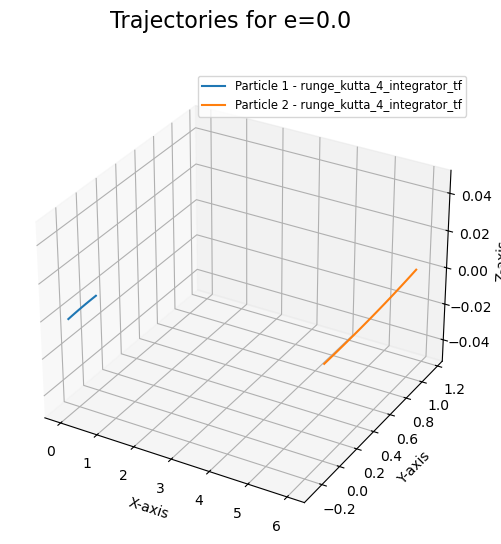

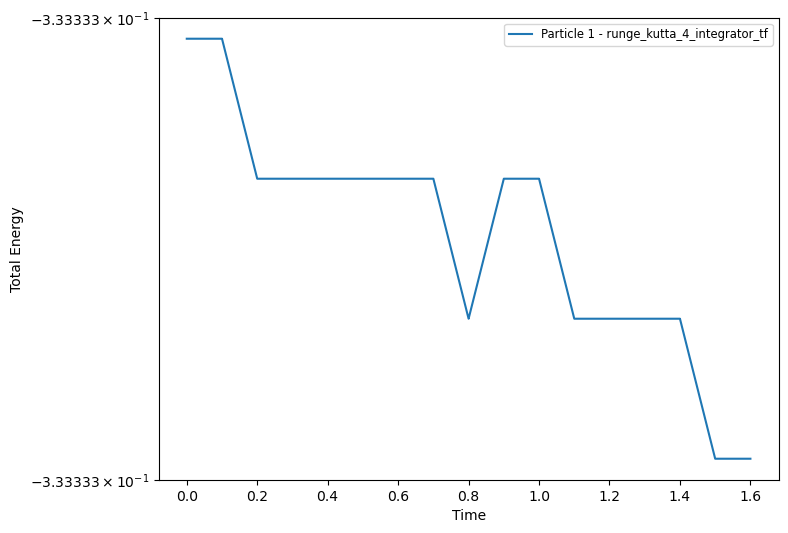

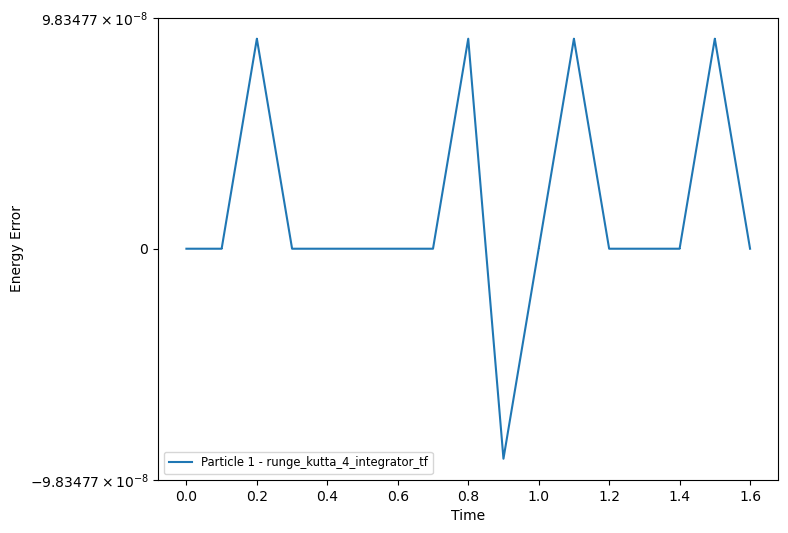

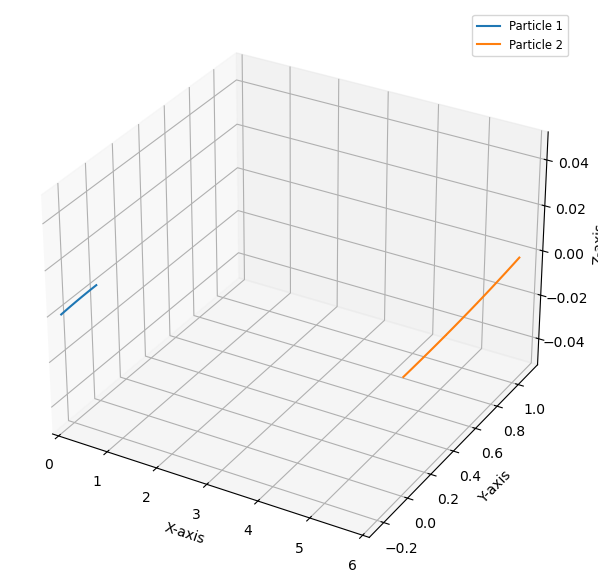

In [41]:
dt = 0.1
eccentricities = [0.]#, 0.5, 0.99]

for e in eccentricities:
    fig_trajectory, ax_trajectory = plt.subplots(figsize=(8, 6), subplot_kw={'projection': '3d'})
    fig_energy, ax_energy = plt.subplots(figsize=(8, 6))
    fig_energy_loss, ax_energy_loss = plt.subplots(figsize=(8, 6))

    planets = fic_tf.ic_two_body(mass1=4., mass2=1., rp=6., e=e)
    position, _, _, potential, t, tot_en, error = simulate_trajectory_tf(fint.runge_kutta_4_integrator_tf, planets.copy(), dt, fdyn.acceleration_tf, potential=True)
    position_np = position.numpy()# Converting position to numpy for plotting
    
    plot_trajectory(position_np, ax_trajectory, 'runge_kutta_4_integrator_tf')
    plot_energy(tot_en.numpy(), ax_energy, 'runge_kutta_4_integrator_tf')
    plot_energy_loss(error.numpy(), ax_energy_loss, 'runge_kutta_4_integrator_tf')

    fig_trajectory.suptitle(f'Trajectories for e={e}', fontsize=16)
    # fig_energy.suptitle(f'Energy for e={e}', fontsize=16)
    # fig_energy_loss.suptitle(f'Energy Loss for e={e}', fontsize=16)


    ############ Animation #######################

    # Create a new figure for animation
    fig_animation, ax_animation = plt.subplots(figsize=(8, 6), subplot_kw={'projection': '3d'})

    # Setup lines for animation
    num_particles = position_np.shape[1]
    lines = []
    for i in range(num_particles):
        line, = ax_animation.plot([], [], [], marker=',', label=f'Particle {i + 1}')
        lines.append(line)

    ax_animation.set_xlim(np.min(position_np[:, :, 0]), np.max(position_np[:, :, 0]))
    ax_animation.set_ylim(np.min(position_np[:, :, 1]), np.max(position_np[:, :, 1]))
    ax_animation.set_zlim(np.min(position_np[:, :, 2]), np.max(position_np[:, :, 2]))
    
    ax_animation.set_xlabel('X-axis')
    ax_animation.set_ylabel('Y-axis')
    ax_animation.set_zlabel('Z-axis')
    ax_animation.legend(fontsize='small')

    # Create the animation
    ani = FuncAnimation(fig_animation, animate, frames=len(position_np), fargs=(position_np, lines), interval=50, blit=True)

    # Save the animation
    ani.save(f'trajectory_animation_e_{e}.mp4', writer='ffmpeg', dpi=300)

    # Show static plots
    plt.tight_layout()
    plt.show()

    # Show animation plot separately
    plt.show(fig_animation)

Simulation Progress:   0%|          | 0/6324 [00:00<?, ?it/s]

/tmp/ipykernel_60137/1012397947.py:25: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax_animation.set_zlim(np.min(position_np[:, :, 2]), np.max(position_np[:, :, 2]))


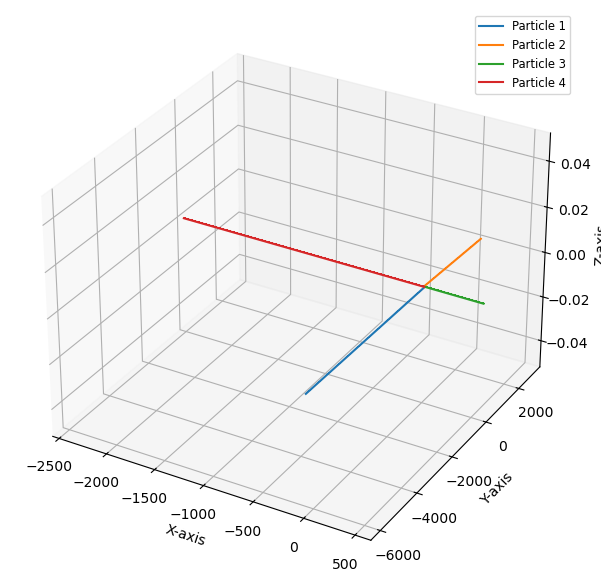

In [52]:
dt = 0.1
eccentricities = [0.5]#, 0.5, 0.99]

for e in eccentricities:

 ############ Animation #######################

    # Create a new figure for animation
    fig_animation, ax_animation = plt.subplots(figsize=(8, 6), subplot_kw={'projection': '3d'})

    
    planets = manual_initial_conditions()
    position, _, _, potential, t, tot_en, error = simulate_trajectory_tf(fint.runge_kutta_4_integrator_tf, planets.copy(), dt, fdyn.acceleration_tf, potential=True,softening = 4.)
    position_np = position.numpy()# Converting position to numpy for plotting

    # Setup lines for animation
    num_particles = position_np.shape[1]
    lines = []
    for i in range(num_particles):
        line, = ax_animation.plot([], [], [], marker=',', label=f'Particle {i + 1}')
        lines.append(line)

    ax_animation.set_xlim(np.min(position_np[:, :, 0]), np.max(position_np[:, :, 0]))
    ax_animation.set_ylim(np.min(position_np[:, :, 1]), np.max(position_np[:, :, 1]))
    ax_animation.set_zlim(np.min(position_np[:, :, 2]), np.max(position_np[:, :, 2]))
    
    ax_animation.set_xlabel('X-axis')
    ax_animation.set_ylabel('Y-axis')
    ax_animation.set_zlabel('Z-axis')
    ax_animation.legend(fontsize='small')

    # Create the animation
    ani = FuncAnimation(fig_animation, animate, frames=len(position_np), fargs=(position_np, lines), interval=50, blit=True)

    # Save the animation
    ani.save(f'trajectory_animation_e_{e}.mp4', writer='ffmpeg', dpi=300)
    plt.tight_layout()
    plt.show(fig_animation)